FF aan gabe vragen morgen, waarom wij geen waardes voor RfR krijgen, waardoor al die convergence shit niet werkt en we een andere problem formulation moeten gebruiken

In [11]:
# import all modules, some might not be necessary (DIE NOG VERWIJDEREN)
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Constraint,
)
from ema_workbench.em_framework.optimization import EpsilonProgress, epsilon_nondominated
from ema_workbench.util import ema_logging

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem, ArchiveLogger
from custom_problem_formulation_no_RfR import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd


In [12]:
ema_logging.log_to_stderr(ema_logging.INFO)

model, steps = get_model_for_problem_formulation()
problem = to_problem(model, searchover="levers")

In [13]:
# load the selected scenarios
scenarios_df = pd.read_csv('results/selected_scenarios.csv')
scenarios_df.rename(columns={'Unnamed: 0': 'scenario_id'}, inplace=True)
scenarios_df = scenarios_df.set_index('scenario_id')
scenarios_df

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
scenario_id,,,,,,,,,,,,,,,,,,,
12275,26,210.807918,1.5,0.092027,172.374261,1.5,0.517100,254.006564,1.0,0.915031,165.440227,10.0,0.235617,183.021862,10.0,0.342190,2.5,1.5,3.5
39833,101,123.723596,10.0,0.087285,315.055206,1.0,0.019649,34.954835,10.0,0.305029,145.432329,1.0,0.862907,209.075297,1.5,0.009042,1.5,3.5,3.5
35280,119,84.948477,10.0,0.294570,305.283047,10.0,0.702650,220.064913,1.0,0.326005,49.619647,1.5,0.009365,306.976860,10.0,0.426481,4.5,3.5,1.5
20422,20,323.962775,1.5,0.190418,328.161863,10.0,0.014162,302.061696,10.0,0.051706,289.845385,1.5,0.059208,83.701692,1.0,0.692434,1.5,1.5,3.5
4717,104,40.525349,10.0,0.161001,187.789168,1.5,0.010373,205.979011,1.0,0.958783,340.402481,1.0,0.086792,75.494126,1.5,0.826855,1.5,1.5,1.5


In [14]:
# scenario_ids = scenarios_df.index.to_list()
# archive_dict = {}
# results_dict = {}
# convergence_dict = {}
# amount_of_seeds = 4

# for scenario in scenario_ids:
#     archive_list = []
#     results_list = []
#     convergence_list = []
#     for i in range(amount_of_seeds):
#         archives = ArchiveLogger.load_archives(f"./archive/Policy_search_arch_{float(scenario)}_seed{i}.tar.gz")
#         for key, df in archives.items():
#             if 'Unnamed: 0' in df.columns:
#                 del df['Unnamed: 0']
#         archive_list.append(archives)

#         result = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}results.csv", index_col=0)
#         results_list.append(result)

#         convergence = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}convergence.csv", index_col=0)
#         convergence_list.append(convergence)

#     archive_dict[scenario] = archive_list
#     results_dict[scenario] = results_list
#     convergence_dict[scenario] = convergence_list

In [15]:
scenario_ids = scenarios_df.index.to_list()
archive_dict = {}
results_dict = {}
convergence_dict = {}
amount_of_seeds = 4

for scenario in scenario_ids:
    archive_list = []
    results_list = []
    convergence_list = []
    for i in range(amount_of_seeds):
        archives = ArchiveLogger.load_archives(f"./archive/Policy_search_arch_{float(scenario)}_seed{i}.tar.gz")
        for key, df in archives.items():
            if 'Unnamed: 0' in df.columns:
                del df['Unnamed: 0']
            # Drop the 'A.1_RfR Costs' and 'A.2_RfR Costs' columns
            df.drop(['A.1_RfR Costs', 'A.2_RfR Costs'], axis=1, inplace=True)
        archive_list.append(archives)

        result = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}results.csv", index_col=0)
        # Drop the 'A.1_RfR Costs' and 'A.2_RfR Costs' columns
        result.drop(['A.1_RfR Costs', 'A.2_RfR Costs'], axis=1, inplace=True)
        results_list.append(result)

        convergence = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}convergence.csv", index_col=0)
        convergence_list.append(convergence)

    archive_dict[scenario] = archive_list
    results_dict[scenario] = results_list
    convergence_dict[scenario] = convergence_list

In [16]:
policy_dict = {}
epsilon = [100, 100, 0.01, 100, 100, 100, 0.01, 100]
for i in range(len(scenario_ids)):
    df = epsilon_nondominated(results_dict[scenario_ids[i]], epsilon, problem) # This function doesn't work properly anymore, we had to change lines 893 and 895 in optimization.py in the em_framework
    policy_dict[scenario_ids[i]] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario_ids[i]} has {n_policies} non-dominated policies")

Scenario 12275 has 19 non-dominated policies
Scenario 39833 has 348 non-dominated policies
Scenario 35280 has 5 non-dominated policies
Scenario 20422 has 128 non-dominated policies
Scenario 4717 has 259 non-dominated policies


In [17]:
# Checking how many unique policies there were at first to get an idea of how many policies were removed
for scenario in scenario_ids:
    # Concatenate DataFrames for all seeds
    df_all_seeds = pd.concat(results_dict[scenario])

    # Drop duplicate rows
    df_unique_policies = df_all_seeds.drop_duplicates()

    # Print the number of unique policies
    print(f"Scenario {scenario} has {df_unique_policies.shape[0]} unique policies")

Scenario 12275 has 71 unique policies
Scenario 39833 has 1366 unique policies
Scenario 35280 has 20 unique policies
Scenario 20422 has 512 unique policies
Scenario 4717 has 1026 unique policies


In [ ]:
con_metrics = {}
for scenario in scenario_ids:
    con_metrics[scenario] = []

for scenario in scenario_ids:
    con_metrics[scenario] = []

    hypervolum = HypervolumeMetric(policy_dict[scenario], problem)
    gen_dist = GenerationalDistanceMetric(policy_dict[scenario], problem, d=1)
    epsilon_ind = EpsilonIndicatorMetric(policy_dict[scenario], problem)
    inverted_gen_dist = InvertedGenerationalDistanceMetric(policy_dict[scenario], problem, d=1)
    spacing_met = SpacingMetric(problem)

    for archives in archive_list:
        metrics = []
        for nfe, archive in archives.items():
            scores = {
                "hypervolume": hypervolum.calculate(archive),
                "generational_distance": gen_dist.calculate(archive),
                "epsilon_indicator": epsilon_ind.calculate(archive),
                "inverted_generational_distance": inverted_gen_dist.calculate(archive),
                "spacing": spacing_met.calculate(archive),
                "nfe": int(nfe),
            }
            metrics.append(scores)
        metrics = pd.DataFrame.from_dict(metrics)

        # sort metrics by number of function evaluations
        metrics.sort_values(by="nfe", inplace=True)
        con_metrics.append(metrics)
    

In [ ]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

ax1, ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")


sns.despine(fig)

plt.show()

<>:50: SyntaxWarning: invalid escape sequence '\e'
<>:50: SyntaxWarning: invalid escape sequence '\e'
/var/folders/mz/j0q1_7_x2f59p13bv_c81xhc0000gn/T/ipykernel_72006/168339671.py:50: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_ylabel("$\epsilon$ progress")


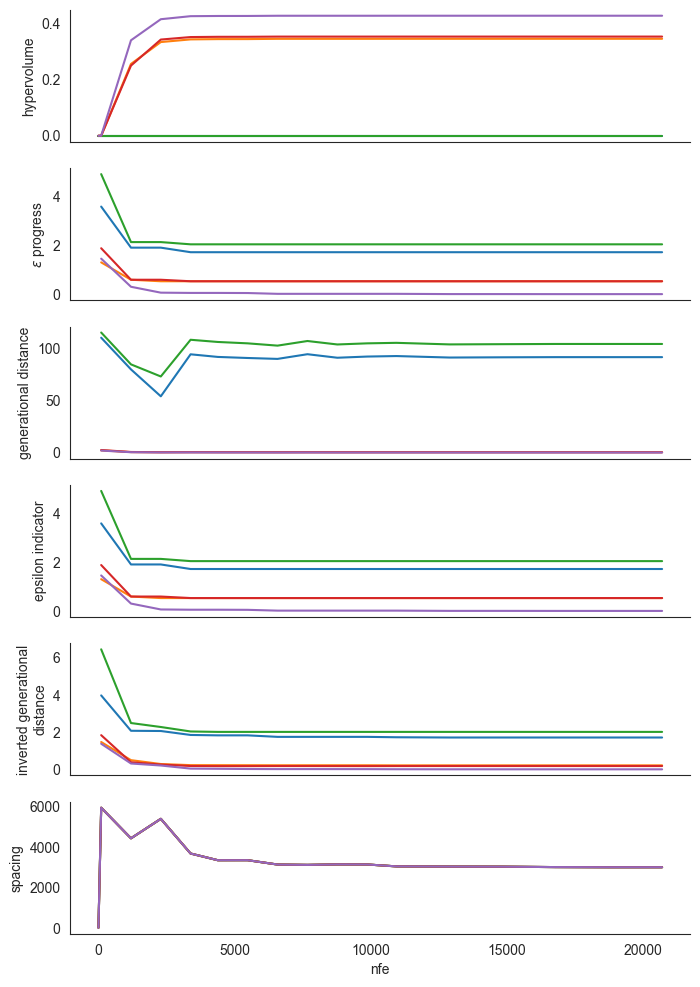

In [21]:
# Initialize the con_metrics dictionary using dictionary comprehension
con_metrics = {scenario: [] for scenario in scenario_ids}

# Function to calculate metrics for each archive
def calculate_metrics_for_archive(archive, hypervolume, gen_dist, epsilon_ind, inverted_gen_dist, spacing_met):
    return {
        "hypervolume": hypervolume.calculate(archive),
        "generational_distance": gen_dist.calculate(archive),
        "epsilon_indicator": epsilon_ind.calculate(archive),
        "inverted_generational_distance": inverted_gen_dist.calculate(archive),
        "spacing": spacing_met.calculate(archive)
    }

# Iterate over each scenario and calculate the metrics
for scenario in scenario_ids:
    hypervolume = HypervolumeMetric(policy_dict[scenario], problem)
    gen_dist = GenerationalDistanceMetric(policy_dict[scenario], problem, d=1)
    epsilon_ind = EpsilonIndicatorMetric(policy_dict[scenario], problem)
    inverted_gen_dist = InvertedGenerationalDistanceMetric(policy_dict[scenario], problem, d=1)
    spacing_met = SpacingMetric(problem)

    # List to store the metrics dataframes for each scenario
    metrics_list = [
        pd.DataFrame.from_dict([
            {
                **calculate_metrics_for_archive(archive, hypervolume, gen_dist, epsilon_ind, inverted_gen_dist, spacing_met),
                "nfe": int(nfe)
            }
            for nfe, archive in archives.items()
        ])
    ]

    # Combine the metrics dataframes into a single dataframe for the scenario and sort by nfe
    combined_metrics = pd.concat(metrics_list).sort_values(by="nfe")
    con_metrics[scenario] = combined_metrics

# Plotting
sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axes

# Plot the metrics for each scenario
for scenario in scenario_ids:
    metrics = con_metrics[scenario]

    ax1.plot(metrics.nfe, metrics.hypervolume, label=f'Scenario {scenario}')
    ax1.set_ylabel("hypervolume")

    ax2.plot(metrics.nfe, metrics.epsilon_indicator, label=f'Scenario {scenario}')
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance, label=f'Scenario {scenario}')
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator, label=f'Scenario {scenario}')
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_generational_distance, label=f'Scenario {scenario}')
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing, label=f'Scenario {scenario}')
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")

# Final plot adjustments
sns.despine(fig)
plt.savefig('./images/convergence_metrics.png')
plt.show()